In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, NNConv, SAGEConv
from tqdm import tqdm
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [4]:
os.getcwd()
use_cuda_if_available = False
BATCH_SIZE = 50
INITIAL_CLASSIFICATION_THRESHOLD = 0.5
device = torch.device('cuda' if torch.cuda.is_available() and use_cuda_if_available else 'cpu')

In [5]:
def set_seed(seed):
    random.seed(seed)                
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed = 1234
set_seed(seed)

# ROC Curve Plot Function

In [6]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_pred_prob, title="ROC Curve"):
    """
    Plots the ROC curve and computes the AUC.

    Parameters:
    - y_true: True labels (array-like, shape = [n_samples])
    - y_pred_prob: Predicted probabilities for the positive class (array-like, shape = [n_samples])
    - title: Title of the plot (default: "ROC Curve")
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()

# Importing the Main tabular data

In [7]:
signal = pd.read_csv('/teamspace/studios/this_studio/GNN/data/signal_gnn.txt', sep = '\t')
background = pd.read_csv('/teamspace/studios/this_studio/GNN/data/background_gnn.txt', sep = '\t')

In [8]:
signal.head()

,isophoton_Eta,isophoton_Phi,isophoton_pT,isophoton_Px,isophoton_Py,isophoton_Pz,isophoton_E,jet1_Eta,jet1_Phi,jet1_pT,...,jet2_Px,jet2_Py,jet2_Pz,jet2_E,jet_multiplicity,deltaR_jet12,deltaR_iso_jet1,deltaR_iso_jet2,inv_mass,label
0,0.214053,2.494540,37.8202,-30.17530,22.79950,8.15751,38.6899,-0.014393,-0.208869,28.6807,...,-3.76972,-22.9190,-2.67784,23.3808,2,1.528268,2.713044,2.081011,90.217625,1
1,1.075320,-2.772420,33.6836,-31.41420,-12.15440,43.61580,55.1083,1.303590,-0.449611,26.0883,...,6.20943,23.4006,18.11700,30.2386,2,1.864275,2.333998,2.232534,86.379330,1
2,-1.147960,2.543960,36.5321,-30.20000,20.55610,-51.77440,63.3654,-0.787717,0.477499,35.7932,...,4.66493,-30.1458,-19.97250,36.4614,2,1.902607,2.097626,2.382293,104.956134,1
3,-2.373360,1.110120,14.3928,6.39836,12.89230,-76.57120,77.9121,-0.952813,2.817070,26.9783,...,-5.04668,-23.3203,-1.46524,23.9050,2,1.903799,2.220728,3.704155,89.161722,1
4,0.994138,0.083512,29.8721,29.76800,2.49179,34.83620,45.8901,1.871150,2.811970,29.2314,...,-2.47796,-26.1381,125.54400,128.2600,2,1.849136,2.865943,2.164006,96.848533,1


In [9]:
background.columns

Index(['isophoton_Eta', 'isophoton_Phi', 'isophoton_pT', 'isophoton_Px',
       'isophoton_Py', 'isophoton_Pz', 'isophoton_E', 'jet1_Eta', 'jet1_Phi',
       'jet1_pT', 'jet1_Px', 'jet1_Py', 'jet1_Pz', 'jet1_E', 'jet2_Eta',
       'jet2_Phi', 'jet2_pT', 'jet2_Px', 'jet2_Py', 'jet2_Pz', 'jet2_E',
       'jet_multiplicity', 'deltaR_jet12', 'deltaR_iso_jet1',
       'deltaR_iso_jet2', 'inv_mass', 'label'],
      dtype='object')

# Plan for defining the Graph

Individual Event -> Graph -> Fully Connected Graph, Undirectional

Objects(Isophoton, jet1, jet2) -> Nodes

Node Lable -> (isophoton, jet1, jet2) -> (0,1,2)

Node Features -> (Eta, Phi, pT, Px, Py, Pz, E)

Edge Index -> ((0, 1, 2),(1, 2, 0))

Edge Features -> $\Delta R$ between the ((0,1), (1,2), (2,0))

Graph Features -> (jet_multiplicity, inv_mass

Graph Lable -> 0:Background, 1:Signal

# Aggregating Node Features

In [10]:
def get_node_features(x:pd.DataFrame) -> list:
    """
    Extracts node features for isophoton, jet1, and jet2 from a DataFrame
    and returns a list of node features for all events.

    Parameters:
    -----------
    x : pd.DataFrame
        Input DataFrame with columns containing features for each object in the event.

    Returns:
    --------
    list_of_node_features : list of lists
        Each element in the list is a 2D list of shape (3, num_features) 
        containing node features for isophoton, jet1, and jet2.
    """
    # List to store node features for all events (graphs)
    list_of_node_features = []

    # Columns for each object's features
    isophoton_cols = ['isophoton_Eta', 'isophoton_Phi', 'isophoton_pT', 
                      'isophoton_Px', 'isophoton_Py', 'isophoton_Pz', 'isophoton_E']
    jet1_cols = ['jet1_Eta', 'jet1_Phi', 'jet1_pT', 
                 'jet1_Px', 'jet1_Py', 'jet1_Pz', 'jet1_E']
    jet2_cols = ['jet2_Eta', 'jet2_Phi', 'jet2_pT', 
                 'jet2_Px', 'jet2_Py', 'jet2_Pz', 'jet2_E']

    for _, event in x.iterrows():
        isophoton_features = event[isophoton_cols].values.tolist()  # List of features for isophoton
        jet1_features = event[jet1_cols].values.tolist()            # List of features for jet1
        jet2_features = event[jet2_cols].values.tolist()            # List of features for jet2

        event_node_features = [isophoton_features, jet1_features, jet2_features]

        list_of_node_features.append(event_node_features)

    return list_of_node_features

In [11]:
signal_node_features_list = get_node_features(signal)
background_node_features_list = get_node_features(background)

In [12]:
# Shape of node_features_list
print(len(signal_node_features_list))           # Number of events (graphs)
print(len(signal_node_features_list[0]))        # Number of nodes (3: isophoton, jet1, jet2)
print(len(signal_node_features_list[0][0]))     # Number of features per node

886
3
7


In [13]:
# Shape of node_features_list
print(len(background_node_features_list))           # Number of events (graphs)
print(len(background_node_features_list[0]))        # Number of nodes (3: isophoton, jet1, jet2)
print(len(background_node_features_list[0][0]))     # Number of features per node

1529
3
7


In [14]:
signal_node_features_list[0] #Each Row represents node feature

[[0.214053, 2.49454, 37.8202, -30.1753, 22.7995, 8.15751, 38.6899],
 [-0.0143928, -0.208869, 28.6807, 28.0573, -5.94704, -0.412809, 28.6837],
 [-0.115036, -1.73382, 23.2269, -3.76972, -22.919, -2.67784, 23.3808]]

# Aggregating Edge Index and Edge Features

In [15]:
edge_index = [[0,1,2],[1,2,0]]  #Directed edge (0 -> 1, 1 -> 2, 2 -> 0)

def get_edge_features(x:pd.DataFrame) -> list:
    """
    Extracts edge features(deltaR) between isophoton, jet1, and jet2 from a DataFrame
    and returns a list of edge features for all events.

    Parameters:
    -----------
    x : pd.DataFrame
        Input DataFrame with columns containing features for each object in the event.

    Returns:
    --------
    list_of_edge_features : list of lists
        Each element in the list is a 1D list of size 3 
        containing edge features for isophoton, jet1, and jet2.
    """

    list_of_edge_features = []

    for _, event in x.iterrows():
        edge_01 = event['deltaR_iso_jet1']
        edge_12 = event['deltaR_jet12']
        edge_20 = event['deltaR_iso_jet2']
        
        list_of_edge_features.append([edge_01, edge_12, edge_20])
    return list_of_edge_features

In [16]:
signal_edge_features_list = get_edge_features(signal)
background_edge_features_list = get_edge_features(background)

In [17]:
print(len(signal_edge_features_list))
print(len(signal_edge_features_list[0]))

886
3


In [18]:
signal_edge_features_list[0]

[2.713043992422283, 1.5282684993505689, 2.0810109593528523]

In [19]:
print(len(background_edge_features_list))
print(len(background_edge_features_list[0]))

1529
3


# Aggregating Data for Graphs

In [20]:
def get_graph_features(node_features_list:list, edge_features_list:list, edge_index_list:list) -> dict:
    '''
    Extract node features,  edge features and edge index for each event and put then into a dictionary
    representating each event and return a list containing the dictionaries.

    Parameters:
    -----------
    node_features_list : list
        Each element in the list is a 2D list of shape (3, num_features) 
        containing node features for isophoton, jet1, and jet2.

    edge_features_list : list
        Each element in the list is a 1D list of size 3 
        containing edge features for isophoton, jet1, and jet2.

    edge_index_list : list
        2D list of shape (2, num_edges), connectivity information.

    Returns:
    --------
    event_graph : list of dictionaries
        Each element contains:
            - 'nodes': 2D list of shape (3, num_features), node features for isophoton, jet1, and jet2.
            - 'edges': 2D list of shape (num_edges, edge_features), edge features (Delta R) for the fully connected graph.
            - 'edge_index': 2D list of shape (2, num_edges), connectivity information.
    '''
    event_graphs = []
    if len(node_features_list) == len(edge_features_list):
        for i in range(len(node_features_list)):
            graph_dict = {
                'nodes' : node_features_list[i],
                'edges' : edge_features_list[i],
                'edge_index' : edge_index_list
            }
            event_graphs.append(graph_dict)
        return event_graphs

    else:
        print('Number of Events in lists dont match')

In [21]:
signal_graphs = get_graph_features(signal_node_features_list, signal_edge_features_list, edge_index)
background_graphs = get_graph_features(background_node_features_list, background_edge_features_list, edge_index)

In [22]:
print(len(signal_graphs))
print(len(signal_graphs[0]))

886
3


In [23]:
signal_graphs[0]

{'nodes': [[0.214053, 2.49454, 37.8202, -30.1753, 22.7995, 8.15751, 38.6899],
  [-0.0143928, -0.208869, 28.6807, 28.0573, -5.94704, -0.412809, 28.6837],
  [-0.115036, -1.73382, 23.2269, -3.76972, -22.919, -2.67784, 23.3808]],
 'edges': [2.713043992422283, 1.5282684993505689, 2.0810109593528523],
 'edge_index': [[0, 1, 2], [1, 2, 0]]}

# Converting Each Event into a PyG Graph Object

In [24]:
import torch
from torch_geometric.data import Data

def convert_to_pyg_graph(graph, jet_multiplicity, inv_mass, deltaR_jet12, label):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'nodes', 'edges', and 'edge_index' for a single event.
    jet_multiplicity : float
        The number of jets in the event.
    inv_mass : float
        The invariant mass of the event.
    label : int
        The label of the event (1 for signal, 0 for background).

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    node_features = torch.tensor(graph['nodes'], dtype=torch.float)  # Shape: (3, num_features)
    edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)

    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([jet_multiplicity, inv_mass, edge_features.std().item(), deltaR_jet12], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor([label], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.jet_multiplicity = graph_level_features[0, 0]
    data.inv_mass = graph_level_features[0, 1]
    data.proximity_spread = graph_level_features[0, 2]
    data.deltaR_jet12 = graph_level_features[0, 3]

    return data

def convert_all_to_pyg_graphs(graphs, dataframe):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jet_multiplicity', 'inv_mass', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    for i, graph in enumerate(graphs):
        # Extract jet_multiplicity, inv_mass and event label for each event
        jet_multiplicity = dataframe.loc[i, 'jet_multiplicity']
        inv_mass = dataframe.loc[i, 'inv_mass']
        deltaR_jet12 = dataframe.loc[i, 'deltaR_jet12']
        label = dataframe.loc[i, 'label']  # 0 for background, 1 for signal

        # Convert to PyTorch Geometric Data object
        data = convert_to_pyg_graph(graph, jet_multiplicity, inv_mass, deltaR_jet12, label)
        pyg_graphs.append(data)

    return pyg_graphs


signal_pyg_graphs = convert_all_to_pyg_graphs(signal_graphs, signal)
background_pyg_graphs = convert_all_to_pyg_graphs(background_graphs, background)

In [25]:
dataset = signal_pyg_graphs + background_pyg_graphs

In [26]:
signal_pyg_graphs[0]

Data(x=[3, 7], edge_index=[2, 3], edge_attr=[3, 1], y=[1], jet_multiplicity=2.0, inv_mass=90.2176284790039, proximity_spread=0.5928297638893127, deltaR_jet12=1.5282684564590454)

# Train-Test Splits

In [27]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
#val_size = int(val_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [28]:
len(train_loader)

34

In [29]:
len(dataset)

2415

# Graph Visualization

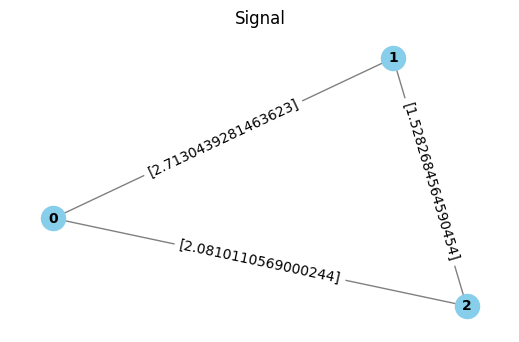

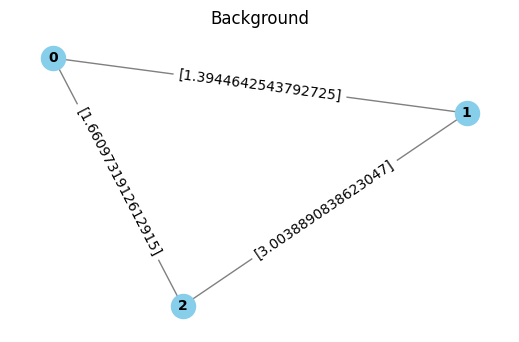

In [30]:
def visualize_graph(data, title):
    """
    Visualize a graph using networkx and matplotlib.
    
    Parameters:
    -----------
    data : Data
        A PyTorch Geometric Data object containing the graph to be visualized.
    """
    # Convert PyTorch Geometric graph to networkx graph
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])

    # Create a plot
    plt.figure(figsize=(5, 3))
    
    # Draw the graph using networkx
    pos = nx.spring_layout(G)  # Layout for positioning nodes
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='skyblue', font_size=10, font_weight='bold', edge_color='gray')

    # Optionally, draw edge weights if you have them
    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title(title)
    plt.show()


visualize_graph(signal_pyg_graphs[0], 'Signal')
visualize_graph(background_pyg_graphs[0], 'Background')

## Model 4 Best

In [54]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        self.classify = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim + num_graph_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, 1)
        )


        ############### Model 4 - Best
        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 16),
             torch.nn.ReLU(),
             torch.nn.Linear(16, hidden_dim * hidden_dim)
        )
        
        self.conv2 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        

    def forward(self, x, edge_index, edge_attr = None, batch = None, data = None):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        # GCN layers
        x = F.relu(self.lin0(x))
        x = F.relu(self.conv2(x, edge_index, edge_attr))
        
        x = global_mean_pool(x, batch)  # Shape: (batch_size, hidden_dim)
        
        graph_features = torch.cat([data.jet_multiplicity.view(-1, 1), data.inv_mass.view(-1, 1), data.proximity_spread.view(-1, 1), data.deltaR_jet12.view(-1, 1)], dim=1)
        x = torch.cat([x, graph_features], dim=1)
        
        # Fully connected layers
        x = self.classify(x)
        x = torch.sigmoid(x)

        return x


# Training and Evaluation Routines

In [57]:
def train(model, loader):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch, data).squeeze()
        loss = criterion(out, data.y.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation loop
def test(model, loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch, data).squeeze()
        pred = (out > INITIAL_CLASSIFICATION_THRESHOLD).float()
        correct += (pred == data.y).sum().item()
    return correct / len(loader.dataset)

## Network Training

In [58]:
model = GCNClassifier(num_node_features=7, num_edge_features = 1, hidden_dim=36, num_graph_features=4)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = torch.nn.BCELoss()

EPOCHS = 250
training_loss = []
test_accuracy = []

with tqdm(total=EPOCHS, desc="Training Progress", leave=True) as pbar:
    for epoch in range(EPOCHS):
        loss = train(model, train_loader)
        acc = test(model, test_loader)
        training_loss.append(loss)
        test_accuracy.append(acc)

        pbar.set_postfix({'Loss': f'{loss:.4f}', 'Accuracy': f'{acc:.4f}'})
        pbar.update(1)

Training Progress: 100%|██████████| 250/250 [01:14<00:00,  3.33it/s, Loss=0.1936, Accuracy=0.7476]


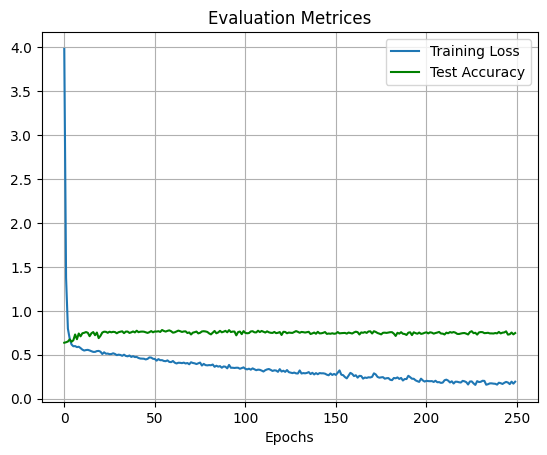

In [60]:
plt.plot([epoch for epoch in range(EPOCHS)], training_loss, label = 'Training Loss')
plt.plot([epoch for epoch in range(EPOCHS)], test_accuracy, color = 'g', label = 'Test Accuracy')
plt.legend()
plt.title('Evaluation Metrices')
plt.xlabel('Epochs')
plt.grid(which = 'both')
#plt.savefig('94auc.png', dpi=200)
plt.show()

y_true = []
y_pred_prob = []
for _, data in enumerate(dataset):
    y_true.append(data.y.numpy()[0])
    out = model(data.x, data.edge_index, data.edge_attr, data.batch, data).squeeze().detach().numpy()
    y_pred_prob.append(float(out))
y_true, y_pred_prob = np.array(y_true), np.array(y_pred_prob)
y_pred_labels = y_pred_prob > INITIAL_CLASSIFICATION_THRESHOLD

LR+: 7.513
LR-: 0.125
Accuracy: 0.884
Precision: 0.813
Recall: 0.889
F1-Score: 0.850


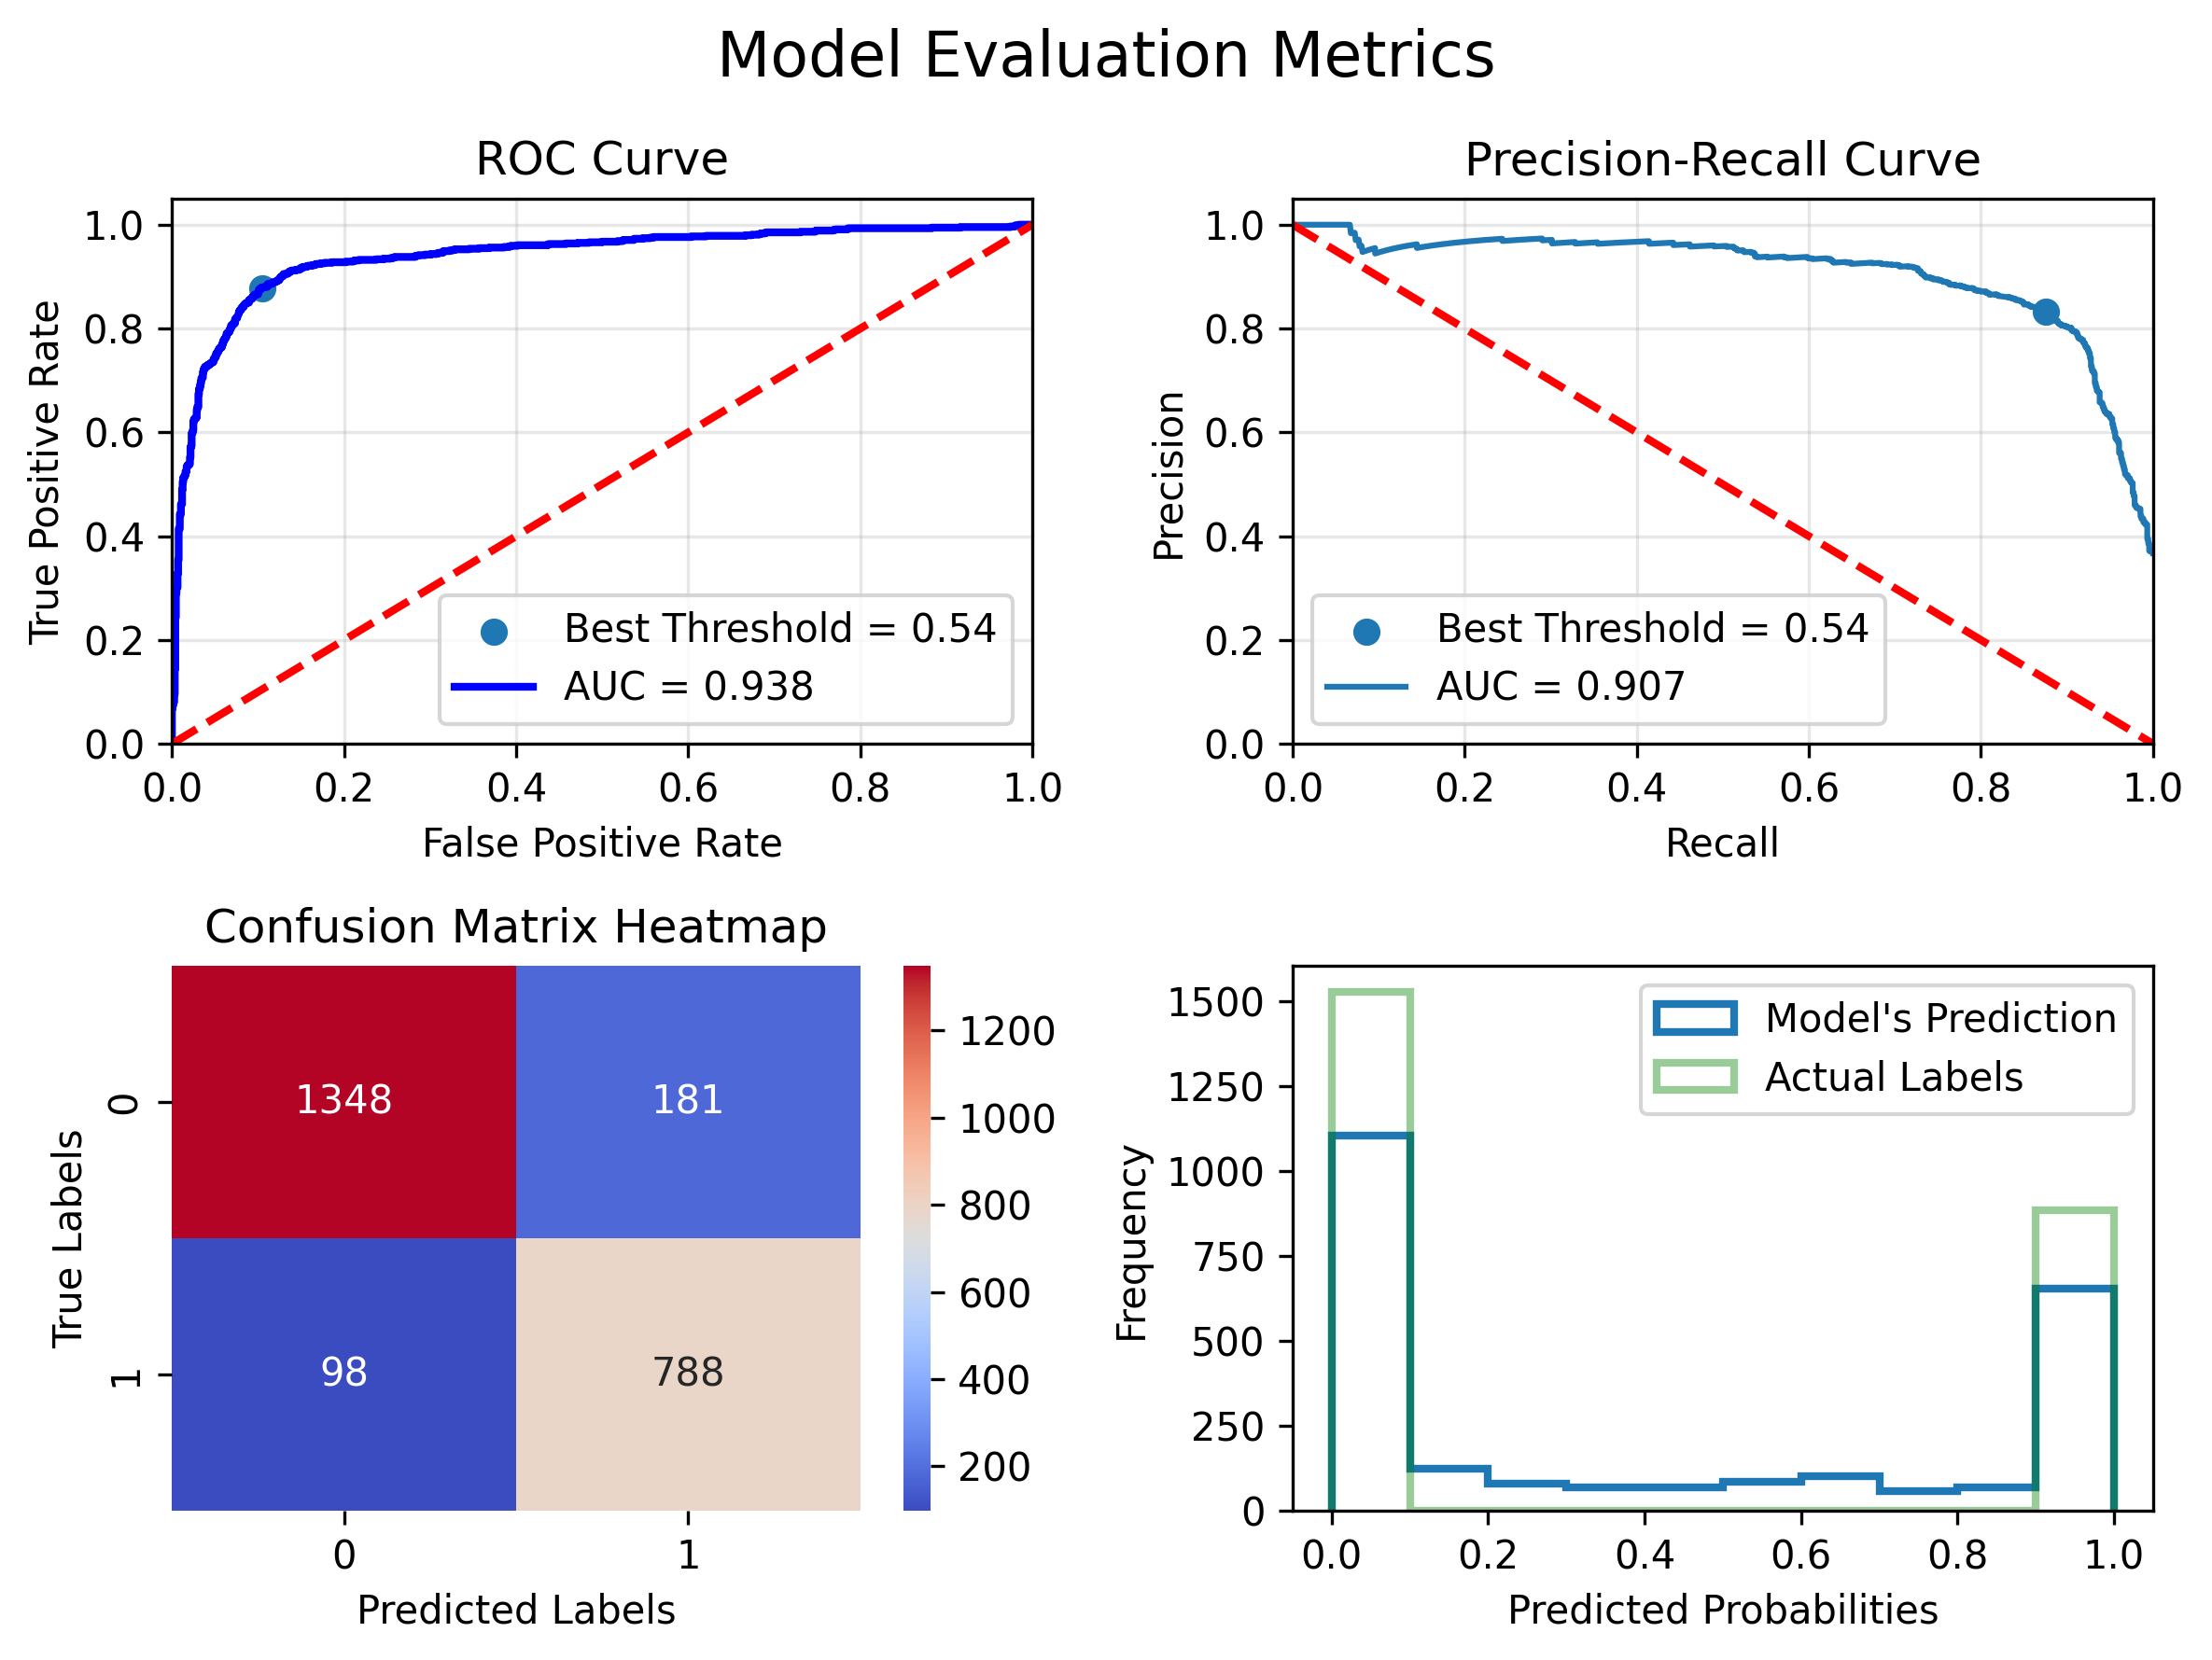

In [61]:
from helper_function_module import eval_model
eval_model(y_true, y_pred_prob, y_pred_labels)

In [62]:
def grad_cam_gnn(model, data, target_class=0):
    """
    Compute Grad-CAM for Graph Neural Network.

    Parameters:
    -----------
    model : torch.nn.Module
        The trained GNN model.
    data : torch_geometric.data.Data
        Input graph data object.
    target_class : int
        The target class index for which Grad-CAM is computed.

    Returns:
    --------
    importance_scores : torch.Tensor
        Node-level importance scores based on Grad-CAM.
    """
    model.eval()
    
    # Ensure gradients are enabled for node features
    data.x.requires_grad_()
    
    # Forward pass
    output = model(data.x, data.edge_index, data.edge_attr, data.batch, data)
    target_output = output
    
    # Backward pass to compute gradients
    target_output.backward(torch.ones_like(target_output))
    
    # Extract gradients for node features
    gradients = data.x.grad  # Shape: [num_nodes, num_features]
    
    # Node importance: Aggregate gradients across features
    importance_scores = gradients.mean(dim=1)  # Shape: [num_nodes]
    
    return importance_scores

importance_scores = grad_cam_gnn(model, background_pyg_graphs[467], target_class=1)
print("Node-level importance scores:", importance_scores.numpy())

Node-level importance scores: [ 2.7354194e-02  1.8549152e-05 -5.8933729e-03]


In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='binary_classification',
        task_level='graph',
        return_type='probs',
    ),
)

data = signal_pyg_graphs[467]
node_index = 1
explanation = explainer(data.x, data.edge_index)
print(f'Generated explanations in {explanation.available_explanations}')

path = 'feature_importance.png'
explanation.visualize_feature_importance(path, top_k=5)
print(f"Feature importance plot has been saved to '{path}'")

path = 'subgraph.pdf'
explanation.visualize_graph(path)
print(f"Subgraph visualization plot has been saved to '{path}'")

In [36]:
# np.save('94aucModel_results', np.vstack((y_true, y_pred)))
# torch.save(model, '94aucModel.pth')